# Coronawiki dataset exploration

The purpose of the following notebook is to get familiar with the given Coronawiki data, as it is split among multiple files which serve different purposes.

As such, we will attempt to do the following tasks in this notebook:

- Preprocessing of the data,to make it more comfortable to use (Split the dataframes, give them another format, etc)
- Data wrangling: a lot of the data are timeseries which could be put together to derive interesting results
- First analysis phase

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pycountry_convert as pc
import os
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Timeseries <a id='timeseries'></a>

The most important data we have in this dataset are time series of the Wikipedia views from 2018 to July 2020 for 14 different languages: one part are the total views for all of that language's wikipedia, a second part are the views for the articles that are related to Covid-19, as well as the percentage. Finally, we also have for the same window of time the views for different topics.

In [2]:
timeseries = pd.read_json("aggregated_timeseries.json.gz")
timeseries.head()

,ja.m,it,da.m,tr,no.m,en,sr,tr.m,en.m,no,...,ko.m,fi.m,sr.m,ja,fr,fi,ca,it.m,sv.m,ko
len,1197788,1594039,256451,346007,516838,6047509,632128,345790,6045654,531478,...,489181,480638,396063,1197856,2195949,481854,642031,1588312,1959446,490314
sum,"{'2018-01-01 00:00:00': 22328288, '2018-01-02 ...","{'2018-01-01 00:00:00': 3338750, '2018-01-02 0...","{'2018-01-01 00:00:00': 765123, '2018-01-02 00...","{'2018-01-01 00:00:00': 407629, '2018-01-02 00...","{'2018-01-01 00:00:00': 715031, '2018-01-02 00...","{'2018-01-01 00:00:00': 86763830, '2018-01-02 ...","{'2018-01-01 00:00:00': 192409, '2018-01-02 00...","{'2018-01-01 00:00:00': 493684, '2018-01-02 00...","{'2018-01-01 00:00:00': 135822131, '2018-01-02...","{'2018-01-01 00:00:00': 224417, '2018-01-02 00...",...,"{'2018-01-01 00:00:00': 1484496, '2018-01-02 0...","{'2018-01-01 00:00:00': 1319053, '2018-01-02 0...","{'2018-01-01 00:00:00': 451383, '2018-01-02 00...","{'2018-01-01 00:00:00': 7828155, '2018-01-02 0...","{'2018-01-01 00:00:00': 6441009, '2018-01-02 0...","{'2018-01-01 00:00:00': 523135, '2018-01-02 00...","{'2018-01-01 00:00:00': 111910, '2018-01-02 00...","{'2018-01-01 00:00:00': 12856884, '2018-01-02 ...","{'2018-01-01 00:00:00': 2383474, '2018-01-02 0...","{'2018-01-01 00:00:00': 819174, '2018-01-02 00..."
covid,"{'len': 30, 'sum': {'2018-01-01 00:00:00': 55,...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 50,...","{'len': 4, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 1, ...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 7, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 57...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 6, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 3, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 91...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 2, ...",...,"{'len': 113, 'sum': {'2018-01-01 00:00:00': 6,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 11, ...","{'len': 30, 'sum': {'2018-01-01 00:00:00': 26,...","{'len': 16, 'sum': {'2018-01-01 00:00:00': 62,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 2, '...","{'len': 49, 'sum': {'2018-01-01 00:00:00': 6, ...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 139...","{'len': 8, 'sum': {'2018-01-01 00:00:00': 19, ...","{'len': 113, 'sum': {'2018-01-01 00:00:00': 3,..."
topics,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 29427...,{'Culture.Biography.Biography*': {'len': 57720...,{'Culture.Biography.Biography*': {'len': 70443...,{'Culture.Biography.Biography*': {'len': 11603...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 37718...,{'Culture.Biography.Biography*': {'len': 70434...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 11804...,...,{'Culture.Biography.Biography*': {'len': 75406...,{'Culture.Biography.Biography*': {'len': 10422...,{'Culture.Biography.Biography*': {'len': 37580...,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 38258...,{'Culture.Biography.Biography*': {'len': 10444...,{'Culture.Biography.Biography*': {'len': 10175...,{'Culture.Biography.Biography*': {'len': 29422...,{'Culture.Biography.Biography*': {'len': 14668...,{'Culture.Biography.Biography*': {'len': 75498...


In [3]:
timeseries.columns

Index(['ja.m', 'it', 'da.m', 'tr', 'no.m', 'en', 'sr', 'tr.m', 'en.m', 'no',
       'sv', 'nl.m', 'nl', 'da', 'de', 'fr.m', 'ca.m', 'de.m', 'ko.m', 'fi.m',
       'sr.m', 'ja', 'fr', 'fi', 'ca', 'it.m', 'sv.m', 'ko'],
      dtype='object')

In [4]:
languages_unique = timeseries.columns.map(lambda x: x[:2]).unique()

Correspondence:
- ja -> Japanese
- it -> Italian
- da -> Danish
- tr -> Turkish
- no -> Norwegian
- en -> English
- sr -> Serbian
- sv -> Swedish
- nl -> Dutch
- de -> German
- fr -> French
- ca -> Catalan
- ko -> Korean
- fi -> Finnish

### Splitting the timeseries data into different dataframes

As we can see, the data's format isn't ideal: for each language, the data is split into 3 Python dictionaries corresponding to the data described above, and it would be nice to separate these pieces of data to be able to read directly for each date, for example, the total number of views accross all languages, instead of having to iterate over each language's dictionnary every time.

This will also make the analysis phase easier later on.

### Total sum of views, views of articles related to Covid

<a id='extraction_format'></a>
In this part of the code we extract two following kind of data, for each date:
- For every language's Wikipedia, the total number of views on that particular date
- For every language's Wikipedia, the total number of views for articles related to Covid-19 on that particular date

---


Every resulting dataframe will have the following format:

 Column name          | Description                                                                                                                                                                                       |   |   |   |
|----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---|---|---|
| date           | A particular date between January 2018 (inclusive) and July of 2020 (inclusive)                                                                                                                                             |   |   |   |
| language       | The corresponding wikipedia language                                                                |  
 |   |   |
| views  | The number of views (total or only for articles related to Covid-19) for this language and date


---



We also extract another dataframe that simply maps for each language the number of articles that were considered in the original experiment. Finally, a last dataframe which is redundant with the two first ones is present: one which gives for each day the percentage of views that went to Covid related articles.

In [5]:
timeseries_total_sum_dict = {}
timeseries_covid_len_dict = {}
timeseries_covid_sum_dict = {}
timeseries_covid_percent_dict = {}
for cn in timeseries.columns:
    timeseries_total_sum_dict[cn] = timeseries[cn]['sum']
    timeseries_covid_len_dict[cn] = timeseries[cn]['covid']['len']
    timeseries_covid_sum_dict[cn] = timeseries[cn]['covid']['sum']
    timeseries_covid_percent_dict[cn] = timeseries[cn]['covid']['percent']

In [6]:
sum_data_df = pd.DataFrame.from_dict(timeseries_total_sum_dict, orient = 'index').T
covid_len_data_df = pd.DataFrame.from_dict(timeseries_covid_len_dict, orient = 'index', columns = ['len']).T
covid_sum_data_df = pd.DataFrame.from_dict(timeseries_covid_sum_dict, orient = 'index').T
covid_percent_data_df = pd.DataFrame.from_dict(timeseries_covid_percent_dict, orient = 'index').T

In [7]:
# Fuse the .m and the normal columns together, and separate the data
new_sum_data_df = pd.DataFrame()
new_covid_sum_data_df = pd.DataFrame()
for language in languages_unique:
    country_sum_data = pd.DataFrame()
    country_sum_data['views'] = sum_data_df[language] + sum_data_df[language + '.m']
    country_sum_data['language'] = language
    new_sum_data_df = pd.concat([new_sum_data_df, country_sum_data], axis = 0)
    
    country_covid_sum_data = pd.DataFrame()
    country_covid_sum_data['views'] = covid_sum_data_df[language] + covid_sum_data_df[language + '.m']
    country_covid_sum_data['language'] = language
    new_covid_sum_data_df = pd.concat([new_covid_sum_data_df, country_covid_sum_data], axis = 0)
    
sum_data_df = new_sum_data_df
covid_sum_data_df = new_covid_sum_data_df

In [8]:
sum_data_df.head()

,views,language
2018-01-01 00:00:00,30156443,ja
2018-01-02 00:00:00,31038338,ja
2018-01-03 00:00:00,33628914,ja
2018-01-04 00:00:00,33870576,ja
2018-01-05 00:00:00,33481670,ja


In [9]:
sum_data_df.index = covid_sum_data_df.index =  pd.to_datetime(sum_data_df.index)
covid_percent_data_df.index = pd.to_datetime(covid_percent_data_df.index)
sum_data_df['date'] = covid_sum_data_df['date'] = sum_data_df.index
covid_percent_data_df['date'] = covid_percent_data_df.index
#covid_sum_data_df = covid_sum_data_df[new_column_order]
#covid_percent_data_df = covid_percent_data_df[new_column_order]

In [10]:
sum_data_df.head()

,views,language,date
2018-01-01,30156443,ja,2018-01-01
2018-01-02,31038338,ja,2018-01-02
2018-01-03,33628914,ja,2018-01-03
2018-01-04,33870576,ja,2018-01-04
2018-01-05,33481670,ja,2018-01-05


In [11]:
covid_sum_data_df.head()

,views,language,date
2018-01-01,81,ja,2018-01-01
2018-01-02,97,ja,2018-01-02
2018-01-03,104,ja,2018-01-03
2018-01-04,160,ja,2018-01-04
2018-01-05,204,ja,2018-01-05


In [12]:
covid_percent_data_df.head()

,ja.m,it,da.m,tr,no.m,en,sr,tr.m,en.m,no,...,fi.m,sr.m,ja,fr,fi,ca,it.m,sv.m,ko,date
2018-01-01,0.000002,0.000015,0.000000,0.000002,0.000010,0.000007,0.000031,0.000006,0.000007,0.000009,...,0.000000,0.000024,0.000003,0.000010,0.000004,0.000054,0.000011,0.000008,0.000004,2018-01-01
2018-01-02,0.000002,0.000019,0.000005,0.000007,0.000009,0.000010,0.000051,0.000004,0.000008,0.000011,...,0.000000,0.000043,0.000005,0.000010,0.000003,0.000030,0.000015,0.000006,0.000021,2018-01-02
2018-01-03,0.000002,0.000023,0.000002,0.000013,0.000004,0.000010,0.000040,0.000004,0.000008,0.000007,...,0.000008,0.000037,0.000005,0.000011,0.000003,0.000048,0.000013,0.000007,0.000019,2018-01-03
2018-01-04,0.000002,0.000019,0.000000,0.000002,0.000004,0.000010,0.000022,0.000019,0.000009,0.000002,...,0.000000,0.000077,0.000010,0.000011,0.000005,0.000049,0.000015,0.000008,0.000017,2018-01-04
2018-01-05,0.000003,0.000022,0.000000,0.000000,0.000003,0.000010,0.000051,0.000004,0.000008,0.000009,...,0.000000,0.000087,0.000011,0.000012,0.000000,0.000024,0.000010,0.000005,0.000021,2018-01-05


### Checking for missing data

Before continuing further, let us check for missing data in the timeseries; this will help us avoid bad surprises later on.

In [13]:
sum_data_df.isnull().any().any(), covid_sum_data_df.isnull().any().any(), covid_percent_data_df.isnull().any().any()

(False, False, True)

There appears to be some missing data in the percentage dataframe; let's check by language where that missing data is reported.

In [14]:
missing_data_language = covid_percent_data_df.isnull().any(axis = 0)
missing_data_language[missing_data_language]

sv    True
dtype: bool

Looking at the paper, this corresponds to Swedish.

In [15]:
#Decomment Run this cell if you want to see how the missing data can be seen in the original timeseries
#timeseries.loc[:,'sv']['sum']

It appears that, for desktop devices, the views for the Swedish Wikipedia haven't been collected for the whole year 2018. The reason for that is unknown, as a quick search tells us that this version has existed since 2001. The mobile data, however, is available. We will need to take this into account when doing our analysis in the future, for example by not taking into account 2018.

### Topics data

Now we will extract for each language, all the views per topic in such a way that the data becomes more usable. In the original data, all topic-related information was in a single dictionnary; we're gonna separate them in a way that each column will correspond to a different topic, with each row being a different language.

In [16]:
country_to_topics = {}
for cn in timeseries.columns:
    country_to_topics[cn] = timeseries[cn]['topics']
topics_df = pd.DataFrame.from_dict(country_to_topics, orient = 'index')

In [17]:
countries_to_topics_len = {}
countries_to_topics_sum = {}
countries_to_topics_percent = {}
for country in topics_df.index:
    countries_to_topics_len[country] = {}
    countries_to_topics_sum[country] = {}
    countries_to_topics_percent[country] = {}
    for topic in topics_df.columns:
        countries_to_topics_len[country][topic] = topics_df.loc[country,topic]['len']
        countries_to_topics_sum[country][topic] = topics_df.loc[country,topic]['sum']
        countries_to_topics_percent[country][topic] = topics_df.loc[country,topic]['percent']
countries_to_topics_len_df = pd.DataFrame.from_dict(countries_to_topics_len, orient = 'index')
countries_to_topics_sum_df = pd.DataFrame.from_dict(countries_to_topics_sum, orient = 'index')
countries_to_topics_percent_df = pd.DataFrame.from_dict(countries_to_topics_percent, orient = 'index')

In [18]:
countries_to_topics_sum_df.head()

,Culture.Biography.Biography*,Culture.Biography.Women,Culture.Food and drink,Culture.Internet culture,Culture.Linguistics,Culture.Literature,Culture.Media.Books,Culture.Media.Entertainment,Culture.Media.Films,Culture.Media.Media*,...,STEM.Computing,STEM.Earth and environment,STEM.Engineering,STEM.Libraries & Information,STEM.Mathematics,STEM.Medicine & Health,STEM.Physics,STEM.STEM*,STEM.Space,STEM.Technology
ja.m,"{'2018-01-01 00:00:00': 6629234, '2018-01-02 0...","{'2018-01-01 00:00:00': 1462146, '2018-01-02 0...","{'2018-01-01 00:00:00': 302934, '2018-01-02 00...","{'2018-01-01 00:00:00': 443986, '2018-01-02 00...","{'2018-01-01 00:00:00': 109480, '2018-01-02 00...","{'2018-01-01 00:00:00': 2140880, '2018-01-02 0...","{'2018-01-01 00:00:00': 97435, '2018-01-02 00:...","{'2018-01-01 00:00:00': 238059, '2018-01-02 00...","{'2018-01-01 00:00:00': 681533, '2018-01-02 00...","{'2018-01-01 00:00:00': 4264889, '2018-01-02 0...",...,"{'2018-01-01 00:00:00': 91338, '2018-01-02 00:...","{'2018-01-01 00:00:00': 72493, '2018-01-02 00:...","{'2018-01-01 00:00:00': 316615, '2018-01-02 00...","{'2018-01-01 00:00:00': 10072, '2018-01-02 00:...","{'2018-01-01 00:00:00': 44902, '2018-01-02 00:...","{'2018-01-01 00:00:00': 485801, '2018-01-02 00...","{'2018-01-01 00:00:00': 76863, '2018-01-02 00:...","{'2018-01-01 00:00:00': 1793359, '2018-01-02 0...","{'2018-01-01 00:00:00': 64445, '2018-01-02 00:...","{'2018-01-01 00:00:00': 264636, '2018-01-02 00..."
it,"{'2018-01-01 00:00:00': 809879, '2018-01-02 00...","{'2018-01-01 00:00:00': 193009, '2018-01-02 00...","{'2018-01-01 00:00:00': 34632, '2018-01-02 00:...","{'2018-01-01 00:00:00': 66037, '2018-01-02 00:...","{'2018-01-01 00:00:00': 23304, '2018-01-02 00:...","{'2018-01-01 00:00:00': 206403, '2018-01-02 00...","{'2018-01-01 00:00:00': 50646, '2018-01-02 00:...","{'2018-01-01 00:00:00': 86717, '2018-01-02 00:...","{'2018-01-01 00:00:00': 395631, '2018-01-02 00...","{'2018-01-01 00:00:00': 1137084, '2018-01-02 0...",...,"{'2018-01-01 00:00:00': 41406, '2018-01-02 00:...","{'2018-01-01 00:00:00': 20273, '2018-01-02 00:...","{'2018-01-01 00:00:00': 51490, '2018-01-02 00:...","{'2018-01-01 00:00:00': 7526, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 15705, '2018-01-02 00:...","{'2018-01-01 00:00:00': 76109, '2018-01-02 00:...","{'2018-01-01 00:00:00': 31334, '2018-01-02 00:...","{'2018-01-01 00:00:00': 383789, '2018-01-02 00...","{'2018-01-01 00:00:00': 18815, '2018-01-02 00:...","{'2018-01-01 00:00:00': 78432, '2018-01-02 00:..."
da.m,"{'2018-01-01 00:00:00': 289706, '2018-01-02 00...","{'2018-01-01 00:00:00': 74001, '2018-01-02 00:...","{'2018-01-01 00:00:00': 13610, '2018-01-02 00:...","{'2018-01-01 00:00:00': 4361, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 4238, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 28733, '2018-01-02 00:...","{'2018-01-01 00:00:00': 8817, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 13707, '2018-01-02 00:...","{'2018-01-01 00:00:00': 47315, '2018-01-02 00:...","{'2018-01-01 00:00:00': 269483, '2018-01-02 00...",...,"{'2018-01-01 00:00:00': 2505, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 3840, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 6923, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 226, '2018-01-02 00:00...","{'2018-01-01 00:00:00': 1783, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 12618, '2018-01-02 00:...","{'2018-01-01 00:00:00': 3836, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 62767, '2018-01-02 00:...","{'2018-01-01 00:00:00': 2775, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 7414, '2018-01-02 00:0..."
tr,"{'2018-01-01 00:00:00': 98424, '2018-01-02 00:...","{'2018-01-01 00:00:00': 14151, '2018-01-02 00:...","{'2018-01-01 00:00:00': 3154, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 7279, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 9300, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 14074, '2018-01-02 00:...","{'2018-01-01 00:00:00': 3511, '2018-01-02 00:0...","{'2018-01-01 00:00:00': 3366, '2018-01-02 00:0...","{'2018-01-01 00:00:00'

In [19]:
# Decomment and run this cell to see all available topics.
#countries_to_topics_sum_df.columns

However, we are not be interested in all available topics. As a matter of fact, for our project, it is only useful to isolate the data about articles related to the environment. Examining the columns, the topic is available in only one of them, so we will extract only that topic in two dataframes that have the same format as [here](#extraction_format) (only difference is that we change the name *views* to *environment_views*).

In [20]:
sum_environment_df = countries_to_topics_sum_df['STEM.Earth and environment']
percent_environment_df = countries_to_topics_percent_df['STEM.Earth and environment']
country_to_env_data_sum = {}
country_to_env_data_percent = {}
for country in sum_environment_df.index:
    country_to_env_data_sum[country] = sum_environment_df[country]
    country_to_env_data_percent[country] = percent_environment_df[country]
sum_environment_df = pd.DataFrame.from_dict(country_to_env_data_sum, orient = 'index').T
percent_environment_df = pd.DataFrame.from_dict(country_to_env_data_percent, orient = 'index').T
percent_environment_df.index = pd.to_datetime(percent_environment_df.index)

new_sum_environment_df = pd.DataFrame()
for language in languages_unique:
    country_env_sum_data = pd.DataFrame()
    
    country_env_sum_data['environment_views'] = sum_environment_df[language] + sum_environment_df[language + '.m']
    country_env_sum_data['language'] = language
    new_sum_environment_df = pd.concat([new_sum_environment_df, country_env_sum_data], axis = 0)
sum_environment_df = new_sum_environment_df
sum_environment_df.index = pd.to_datetime(sum_environment_df.index)
sum_environment_df['date'] = sum_environment_df.index

In [21]:
sum_environment_df

,environment_views,language,date
2018-01-01,110497,ja,2018-01-01
2018-01-02,142849,ja,2018-01-02
2018-01-03,162644,ja,2018-01-03
2018-01-04,171022,ja,2018-01-04
2018-01-05,183210,ja,2018-01-05
...,...,...,...
2020-07-27,16384,fi,2020-07-27
2020-07-28,17269,fi,2020-07-28
2020-07-29,17182,fi,2020-07-29
2020-07-30,15963,fi,2020-07-30


In [22]:
#Not really useful piece of data
percent_environment_df.head()

,ja.m,it,da.m,tr,no.m,en,sr,tr.m,en.m,no,...,ko.m,fi.m,sr.m,ja,fr,fi,ca,it.m,sv.m,ko
2018-01-01,0.001414,0.002589,0.001947,0.003699,0.003708,0.003689,0.002651,0.002373,0.002359,0.005613,...,0.001663,0.003341,0.001607,0.002296,0.003844,0.004212,0.009242,0.001771,0.003260,0.002914
2018-01-02,0.002001,0.003256,0.003672,0.003400,0.004326,0.003676,0.003157,0.002486,0.002764,0.007101,...,0.002024,0.004122,0.002492,0.002560,0.004250,0.005175,0.011023,0.002220,0.003829,0.002810
2018-01-03,0.002074,0.003413,0.004139,0.003760,0.004906,0.003920,0.003244,0.003047,0.003071,0.008214,...,0.001953,0.004057,0.002561,0.002667,0.004465,0.005038,0.011034,0.002311,0.004315,0.003077
2018-01-04,0.002029,0.003580,0.004273,0.003828,0.005288,0.004073,0.003960,0.003057,0.003305,0.008870,...,0.002090,0.004323,0.004285,0.003049,0.004455,0.005400,0.011972,0.002481,0.004363,0.003090
2018-01-05,0.002136,0.003422,0.003925,0.003457,0.004078,0.003883,0.003787,0.002363,0.002930,0.008315,...,0.002155,0.003987,0.003053,0.003345,0.004351,0.005054,0.010285,0.002330,0.003549,0.003026


### Plots

In the following part, we save the following type of plots:

- per language on Wikipedia, three separate line plots showing the evolution of the total number of views, the number of views of articles related to Covid-19, and the number of views of environment articles. 
- per language on Wikipedia, three separate histograms representing the number of views per day, for the same categories as in the point above.

These plots can be found in the 'Figures' folder that will be created after the launch of all cells in this part, but we will plot some examples in the notebook to try and detect some patterns.

In [23]:
figures_path = './Figures/'
timeseries_path = 'timeseries/'
hists_path = 'hists/'
total_views_path = 'all_views/'
covid_views_path = 'covid_views/'
topic_views_path = 'topic_views/'
def make_sub_dirs(main_dir):
    os.mkdir(main_dir + total_views_path)
    os.mkdir(main_dir + covid_views_path)
    os.mkdir(main_dir + topic_views_path)
    os.mkdir(main_dir + topic_views_path + total_views_path)
    os.mkdir(main_dir + topic_views_path + covid_views_path)

In [24]:
if not os.path.exists(figures_path):
    os.mkdir(figures_path)
    os.mkdir(figures_path + timeseries_path)
    os.mkdir(figures_path + hists_path)
    make_sub_dirs(figures_path + timeseries_path)
    make_sub_dirs(figures_path + hists_path)

In [25]:
def lineplot_language_views_timeseries(data, country, covid_views = False):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    filtered_data = data[data['language'] == country]
    x = filtered_data.index
    y = filtered_data.views
    g = sns.lineplot( x = x, y = y)
    plt.xticks(fontsize=8)
    g.set(xlabel='Dates')
    if covid_views:
        title = 'Wikipedia page views for articles related to Covid-19 for {}'.format(country)
    else:
        title = 'Wikipedia page views for {}'.format(country)
    g.set(ylabel='Page views', title = title)
    #ax.set(xscale="log")
    if covid_views:
        plt.savefig(figures_path + timeseries_path + covid_views_path + title + ".jpg")
    else:
        plt.savefig(figures_path + timeseries_path + total_views_path + title + ".jpg")
    plt.close(fig)
    #plt.show()

In [26]:
def hist_language_views(data, country, covid_views = False):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    filtered_data = data[data['language'] == country]
    g = sns.histplot(data = filtered_data, x = 'views', bins = 50)
    if covid_views:
        title = 'Wikipedia views distribution for articles related to Covid-19 {}'.format(country)
    else:
        title = 'Wikipedia views distribution for {}'.format(country)
    g.set(title = title)
    if covid_views:
        plt.savefig(figures_path + hists_path + covid_views_path + title + ".jpg")
    else:
        plt.savefig(figures_path + hists_path + total_views_path + title + ".jpg")
    
    plt.close(fig)

In [27]:
for country_code in sum_data_df.language.unique():
    lineplot_language_views_timeseries(sum_data_df, country_code)
    hist_language_views(sum_data_df, country_code)
    lineplot_language_views_timeseries(covid_sum_data_df, country_code, True)
    hist_language_views(covid_sum_data_df, country_code, True)

In [28]:
def lineplot_topic_views_timeseries(topic_data, country, covid_views = False, topic = 'environment'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    filtered_data = topic_data[topic_data['language'] == country]
    x = filtered_data.index
    y = filtered_data.environment_views
    g = sns.lineplot( x = x, y = y)
    plt.xticks(fontsize=8)
    g.set(xlabel='Dates')
    if covid_views:
        title = 'Wikipedia page views for articles related to Covid-19 for {0} for the {1} topic'.format(country, topic)
    else:
        title = 'Wikipedia page views for {0} for the {1} topic'.format(country,topic)
    g.set(ylabel='Page views', title = title)
    if covid_views:
        plt.savefig(figures_path + timeseries_path + topic_views_path + covid_views_path + title + ".jpg")
    else:
        plt.savefig(figures_path + timeseries_path + topic_views_path + total_views_path + title + ".jpg")
        
    plt.close(fig)

In [29]:
def hist_topic_views(topic_data, country, covid_views = False, topic = 'environment'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    filtered_data = topic_data[topic_data['language'] == country]
    g = sns.histplot(data = filtered_data, x = 'environment_views', bins = 50)
    if covid_views:
        title = 'Wikipedia views distribution for articles related to Covid-19 for {0} for the {1} topic'.format(country, topic)
    else:
        title = 'Wikipedia views distribution for {0} for the {1} topic'.format(country, topic)
    g.set(title = title)
    if covid_views:
        plt.savefig(figures_path + hists_path + topic_views_path + covid_views_path + title + ".jpg")
    else:
        plt.savefig(figures_path + hists_path + topic_views_path + total_views_path + title + ".jpg")
    
    plt.close(fig)

In [30]:
for country_code in sum_environment_df.language.unique():
    lineplot_topic_views_timeseries(sum_environment_df, country_code)
    hist_topic_views(sum_environment_df, country_code)

Let us plot some of the environment views timeseries here, to try and see if some interesting patterns can be seen already. We will choose the Serbian and Danish languages for this part. Note that we're not comparing the values themselves but whether or not there are patterns in either of them, so sharing the y-axis isn't really needed here. 

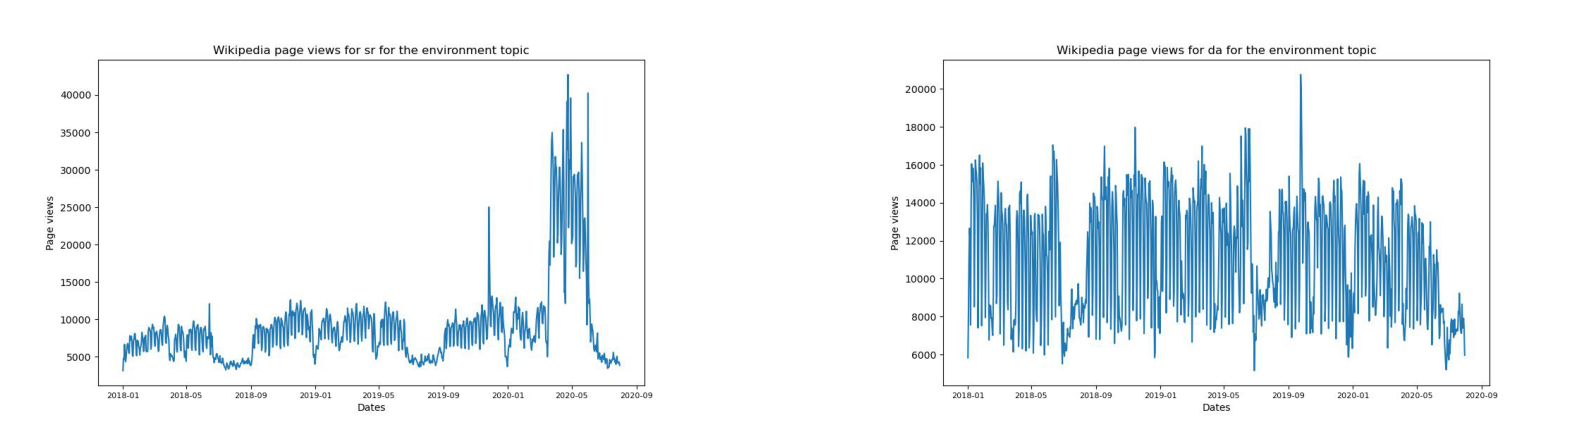

In [31]:
countries_chosen = [ 'sr', 'da']
fig, ax = plt.subplots(nrows = 1, ncols = len(countries_chosen),figsize=(20, 10), dpi=100)
for i in range(len(countries_chosen)):
    filename = "Wikipedia page views for {} for the environment topic.jpg".format(countries_chosen[i])
    ax[i].imshow(plt.imread(fname = './Figures/timeseries/topic_views/all_views/' + filename))
    ax[i].axis('off')
#_ = plt.axis('off')

We can see a slight difference in behavior between these languages around the beginning of 2020:
- first, we can see that while the environment views are pretty low before 2020 for the serbian wikipedia, these views go up quickly around the end of March 2020, which when looking at the intervention data seems to coincide with the first serbian lockdown. It is still a bit early however to affirm that one of these elements caused the other.
- moving to the danish wikipedia however, there doesn't seem to be a particular rise or fall in the number of environment views.

We can also see however that for both languages, there seems to be a pattern of evolution of views between the years: for serbian, there is clear decrease between June and Septembre of both 2018 and 2019, which seems to have happened in 2020 as well if we look at the left plot. For danish the same phenomena can be observed as well, this time between July and August of both 2018 and 2019; again, this seems to have happened in 2020 as well if we were to look at the right plot. Looking at the other languages, patterns can also be found accross years.

It appears that indeed, the number of views for environmental articles did change in the same timeframe as when Covid-19 first arrived in some of the countries. It's equally important, however, to state that some don't display a change in pattern, and that at this point in the analysis we can't say that Covid-19 indeed caused more or less environment awareness on Wikipedia.

Let us now do another, more statistical analysis; we will test the hypothesis that, in average, and for every language, the average number of environmental views is the same between 2019 (pre-Covid) and 2020 (during the first, biggest wave of Covid). We will test these hypotheses using the $\alpha = 0.05 $ significance level, as well as using the Bonferonni correction $\alpha_{c} = \frac{\alpha}{n}$, with n = 14 .

We match the same date between 2019 and 2020 (up to the 31st of July, as that's when the Coronawiki data ends) for every language, and conduct a t-test for the null hypothesis described above. Note that we consider the samples to be related, as they come from the same language and for the same range of dates. In this setup, a negative t-statistic means that for that language, there are more environment views on average in 2020, and vice-versa.

In [32]:
before_covid_env_topic_views = sum_environment_df[(sum_environment_df.date < '2020-01-01') & \
                                                  (sum_environment_df.date >= '2019-01-01')]
during_covid_env_topic_views = sum_environment_df[sum_environment_df.date >= '2020-01-01']
for language in sum_environment_df.language.unique():
    language_before = before_covid_env_topic_views[before_covid_env_topic_views.language == language]
    language_during = during_covid_env_topic_views[during_covid_env_topic_views.language == language]
    
    language_before.date = language_before.date.apply(lambda date: str(date.month) + '-' + str(date.day))
    language_during.date = language_during.date.apply(lambda date: str(date.month) + '-' + str(date.day))
    matching = pd.merge(language_before, language_during, on = ['date', 'language'], suffixes = ['_before', '_during'])
    stat, pvalue = stats.ttest_rel(matching['environment_views_before'], matching['environment_views_during'])
    print("p-value for {0}: {1}".format(language, pvalue))
    if(pvalue >= 0.05):
        print("Don't reject null when alpha = 0.05")
    if(pvalue >= (0.05/14)):
        print("Don't reject null when using the banferoni correction")
    print("Ttest statistic value for {0}: {1}".format(language, stat))
    print("------------------")

p-value for ja: 8.674434578237681e-12
Ttest statistic value for ja: -7.231241414327632
------------------
p-value for it: 0.002239652239545297
Ttest statistic value for it: -3.094339981709228
------------------
p-value for da: 8.548804022807578e-09
Ttest statistic value for da: 5.998519188316964
------------------
p-value for tr: 1.314393887625464e-36
Ttest statistic value for tr: -15.476728178676694
------------------
p-value for no: 0.0003371702009370404
Ttest statistic value for no: 3.644641980122951
------------------
p-value for en: 5.111120077771199e-05
Ttest statistic value for en: 4.135571195327151
------------------
p-value for sr: 2.5049354455646286e-18
Ttest statistic value for sr: -9.596560924740071
------------------
p-value for sv: 3.0797434434976986e-10
Ttest statistic value for sv: 6.610574204066698
------------------
p-value for nl: 0.4461336381813529
Don't reject null when alpha = 0.05
Don't reject null when using the banferoni correction
Ttest statistic value for nl:

D:\Miniconda\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


It appears that for 11 out of 14 languages, there is indeed a change in how people visit these pages; the null hypothesis is rejected even after applying the Bonferonni correction, seeing how small their p-values are.. Out of these 11 languages, 6 observe a negative t-statistic, i.e. an average increase in 2020, while the other 5 observe a positive t-statistic, i.e an average decrease in 2020.

## Mobility data

The second type of data we have are mobility data that come from two different sources. The first one is from Apple, who stopped giving out the data in April 2022, and the second one is from Google, which is still available, and more up-to-date (17th of October).

### Apple mobility

In [33]:
apple_mobility = pd.read_csv("applemobilitytrends-2020-04-20.csv.gz")
apple_mobility.head()

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
0,country/region,Albania,driving,100,95.30,101.43,97.20,103.55,112.67,104.83,...,25.47,24.89,32.64,31.43,30.67,30.00,29.26,22.94,24.55,31.51
1,country/region,Albania,walking,100,100.68,98.93,98.46,100.85,100.13,82.13,...,27.63,29.59,35.52,38.08,35.48,39.15,34.58,27.76,27.93,36.72
2,country/region,Argentina,driving,100,97.07,102.45,111.21,118.45,124.01,95.44,...,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67
3,country/region,Argentina,walking,100,95.11,101.37,112.67,116.72,114.14,84.54,...,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44
4,country/region,Australia,driving,100,102.98,104.21,108.63,109.08,89.00,99.35,...,26.95,31.72,53.14,55.91,56.56,58.77,47.51,36.90,53.34,56.93


In [34]:
print(apple_mobility.transportation_type.unique()) # Three types of transportation
print(apple_mobility.geo_type.unique()) # Granularity

['driving' 'walking' 'transit']
['country/region' 'city']


The mobility data from Apple we have begins in mid-January 2020, and ends that same year in April. This isn't a big time window, and it doesn't appear that there is earlier data as it has been collected specifically for Covid-19 mobility tracking. We could however try to look for newer information (post-April 2020) on the web.

Three types of transportation have been tracked here: driving, walking, and transit. We also have two different granularities about the collected data: either country/world region level, or city level, which are often country capitals.

Per day and region, we have the pourcentage of the usage of every transportation mode according to some pre-pandemic baseline computed in early 2020.

In [35]:
apple_mobility[apple_mobility['region'] == 'Turkey']

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
137,country/region,Turkey,driving,100,103.22,106.28,109.51,139.77,144.21,126.23,...,15.04,19.54,43.99,41.94,40.95,45.06,44.15,15.68,22.23,50.03
138,country/region,Turkey,walking,100,100.97,104.45,105.61,133.40,141.40,100.15,...,14.58,15.69,36.97,34.10,32.68,36.88,35.99,14.23,17.34,40.61


In [36]:
apple_mobility.isnull().any().any() # There doesn't appear to be null data, but some countries don't have all the transportation types (transit, mostly)

False

In [37]:
#Convert dates strings to date times
time_columns = pd.to_datetime(apple_mobility.columns[3:])
apple_mobility.columns = apple_mobility.columns[:3].append(time_columns)

### Global mobility from Google

In [38]:
global_mobility_report = pd.read_csv("Global_Mobility_Report.csv.gz")

D:\Miniconda\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
print(min(global_mobility_report.date.unique()), max(global_mobility_report.date.unique()))
global_mobility_report.date = pd.to_datetime(global_mobility_report.date)

2020-02-15 2020-08-25


The mobility data from Google we have begins in mid-February 2020, and ends that same year in August. This is more than the given Apple data, despite the fact that both collections happened in the context of Covid-19. The full data can be found in the *Outside data* folder.

There are more levels of granularity with this data: for example, for the United Arab Emirates, we might simply talk about the whole country, or it could be specified in the column *sub_region_1* that the row is actually focused on the city of Abu Dhabi. This granularity can be made finer with *sub_region_2*.

Per day and region, we have the **difference** in pourcentage usage of various location types (workplaces, etc) according to some pre-pandemic baseline computed in the early weeks of 2020. The baseline was computed *per day* , as people can have different behaviors depending on whether it's the weekend or not.

In [40]:
global_mobility_report.isnull().sum()/global_mobility_report.shape[0]

country_region_code                                   0.000709
country_region                                        0.000000
sub_region_1                                          0.018154
sub_region_2                                          0.180897
metro_area                                            0.994122
iso_3166_2_code                                       0.813653
census_fips_code                                      0.762436
date                                                  0.000000
retail_and_recreation_percent_change_from_baseline    0.363799
grocery_and_pharmacy_percent_change_from_baseline     0.373900
parks_percent_change_from_baseline                    0.536971
transit_stations_percent_change_from_baseline         0.502960
workplaces_percent_change_from_baseline               0.050385
residential_percent_change_from_baseline              0.499080
dtype: float64

As expected, we have more coarse grained data (no missing data) than finer grained (many sub_region_1 fields are null, and even more sub_region_2 as well). The metropolitan area is very rarely defined, as almost 99.4% of the field is empty values.

Looking at the differences from baseline, we remark scarcity as well; apart from workplace locations which has a missing rate of only around 5.04%, others go from 36.4% (for retail) to 53.7% (for parks).

We can look in more details at the entries which have the missing values for the differences from baseline; let's check the intersection of these missing values, to see for example if the absence of one field implies the absence of the others.

In [41]:
retail_missing = (global_mobility_report.retail_and_recreation_percent_change_from_baseline.isnull())
grocery_pharmecy_missing = (global_mobility_report.grocery_and_pharmacy_percent_change_from_baseline.isnull())
park_missing = (global_mobility_report.parks_percent_change_from_baseline.isnull())
transit_stations_missing = (global_mobility_report.transit_stations_percent_change_from_baseline.isnull())
workplace_missing = (global_mobility_report.workplaces_percent_change_from_baseline.isnull())
residential_missing = (global_mobility_report.residential_percent_change_from_baseline.isnull())

In [42]:
all_missing = retail_missing & grocery_pharmecy_missing & park_missing & transit_stations_missing & workplace_missing & residential_missing

In [43]:
all_missing.any()

False

From the above result, we can conclude that there doesn't appear to be a feature such that if that one is missing, then all the others are missing; this also means that for each entry, there's always at least one feature available.

## Interventions

In this data, each language is mapped to the main country of usage except for English, where the language's usage is very high in multiple countries such that it couldn't be mapped to a single country. As such, for that language, we have most of the data missing.

Per country, the pandemic timeline is represented, such as the first registered case, the first death, etc.

Note that the paper says that nine languages are spoken in a single language, but we have more than that here (reason for that unknown).

In [44]:
interventions = pd.read_csv("interventions.csv")
def transform_column(column_name):
    interventions[column_name] = pd.to_datetime(interventions[column_name])
for intervention in interventions.columns[1:]:
    transform_column(intervention)
interventions

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
1,da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
2,de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
3,it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
4,nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaT,2020-03-16,2020-05-29
5,no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
6,sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
7,sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaT,2020-03-11,2020-06-05
8,ko,2020-01-20,2020-02-20,2020-02-23,NaT,NaT,2020-02-25,2020-04-15
9,ca,2020-01-31,2020-02-13,2020-03-12,2020-03-08,2020-03-14,2020-03-16,NaT


## Topics

Simply maps each considered article to the topics it is related to. A single article can be mapped to multiple topics. The number of articles per topic can be found in the [timeseries](#timeseries) data. 

In [45]:
#loading the data takes a lot of time, and it's not really used right now, so there is no real point to load it for now
#topics_linked = pd.read_csv("topics_linked.csv.xz")
#topics_linked

## Data merging

First of all, let us keep from both mobility datasets only the countries that were considered in the original timeseries. We mapped the english language to Washington DC, the catalan language to Barcelona, and the Korean language both to Seoul and South Korea.

In [46]:
country_to_wiki_code = {'Japan' : 'ja', 'Italy': 'it', 'Denmark': 'da', 'Turkey': 'tr', 'Norway': 'no', 'Serbia': 'sr',\
                       'Sweden': 'sv', 'Netherlands': 'nl', 'Germany': 'de', 'France': 'fr', 'Barcelona': 'ca', \
                        'South Korea': 'ko', 'Finland': 'fi', 'District of Columbia' : 'en', 'Washington DC': 'en', 'Seoul': 'ko'}

In [47]:
def map_countries_to_fine_grained(x):
    if x == 'Spain':
        return 'ca'
    if x == 'United States':
        return 'en'
    if x == 'Seoul':
        return ko
    return country_to_wiki_code[x]

filtered_global_mobility_report = global_mobility_report[global_mobility_report['country_region'].isin(country_to_wiki_code)|\
                                                        global_mobility_report['sub_region_1'].isin(country_to_wiki_code)|\
                                                        global_mobility_report['sub_region_2'].isin(country_to_wiki_code)].copy()
filtered_global_mobility_report.loc[:,'country_region_code'] = filtered_global_mobility_report.country_region.apply(lambda x: map_countries_to_fine_grained(x))
filtered_global_mobility_report.index = range(len(filtered_global_mobility_report))
filtered_global_mobility_report.country_region.unique() # There is data about all countries

array(['Germany', 'Denmark', 'Spain', 'Finland', 'France', 'Italy',
       'Japan', 'South Korea', 'Netherlands', 'Norway', 'Serbia',
       'Sweden', 'Turkey', 'United States'], dtype=object)

In [48]:
# Have to keep for each country only the capital/concerned city data from the 
cities_global_mobility_report = pd.DataFrame()
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['sub_region_1'] == 'Tokyo'] ])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['sub_region_2'] == 'Copenhagen Municipality'] ])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['sub_region_1'] == 'Berlin'] ])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['sub_region_1'] == 'Oslo'] ])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['sub_region_2'] == 'Barcelona'] ])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['sub_region_2'] == 'Helsinki'] ])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['sub_region_2'] == 'Paris'] ])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['sub_region_2'] == 'Metropolitan City of Rome'] ])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['metro_area'] == 'Seoul Metropolitan Area'] ])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['sub_region_2'] == 'Government of Amsterdam'] ])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['metro_area'] == 'Belgrade Metropolitan Area'] ])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['sub_region_2'] == 'Stockholm Municipality'] ])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[(filtered_global_mobility_report['sub_region_1'] == 'Ankara') & (filtered_global_mobility_report['sub_region_2'].isnull())]])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['sub_region_2'] == 'Barcelona'] ])
cities_global_mobility_report = pd.concat([cities_global_mobility_report, filtered_global_mobility_report[filtered_global_mobility_report['sub_region_1'] == 'District of Columbia'] ])
cities_global_mobility_report = cities_global_mobility_report[['country_region_code', 'date', 'retail_and_recreation_percent_change_from_baseline',\
                              'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline',\
                              'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline',\
                              'residential_percent_change_from_baseline']]
cities_global_mobility_report = cities_global_mobility_report.rename(columns={'country_region_code': 'language'})

In [49]:
filtered_apple_mobility = apple_mobility[apple_mobility['region'].isin(country_to_wiki_code)].copy()
print(filtered_apple_mobility.region.unique())
print("-----")
filtered_apple_mobility.region = filtered_apple_mobility.region.apply(lambda x: country_to_wiki_code[x])
filtered_apple_mobility.head()

['Denmark' 'Finland' 'France' 'Germany' 'Italy' 'Japan' 'Netherlands'
 'Norway' 'Serbia' 'Sweden' 'Turkey' 'Barcelona' 'Seoul' 'Washington DC']
-----


,geo_type,region,transportation_type,2020-01-13 00:00:00,2020-01-14 00:00:00,2020-01-15 00:00:00,2020-01-16 00:00:00,2020-01-17 00:00:00,2020-01-18 00:00:00,2020-01-19 00:00:00,...,2020-04-11 00:00:00,2020-04-12 00:00:00,2020-04-13 00:00:00,2020-04-14 00:00:00,2020-04-15 00:00:00,2020-04-16 00:00:00,2020-04-17 00:00:00,2020-04-18 00:00:00,2020-04-19 00:00:00,2020-04-20 00:00:00
31,country/region,da,driving,100,103.67,105.55,104.16,110.40,105.47,103.52,...,71.32,71.54,73.58,77.88,80.32,82.37,85.22,80.85,84.05,85.69
32,country/region,da,transit,100,98.09,98.22,99.55,111.53,108.82,102.06,...,32.59,34.40,35.26,34.36,37.09,37.28,40.06,38.39,42.40,41.87
33,country/region,da,walking,100,99.31,104.04,107.99,131.40,126.32,96.40,...,65.98,69.45,60.65,66.49,70.92,74.24,81.08,82.95,79.49,83.64
39,country/region,fi,driving,100,102.42,105.41,104.46,117.78,120.16,112.58,...,76.06,54.91,74.72,72.53,75.78,76.80,88.83,87.21,86.59,84.52
40,country/region,fi,transit,100,98.58,99.52,101.67,104.50,101.66,98.45,...,34.02,32.26,41.28,39.78,39.22,36.50,40.39,37.89,42.44,46.86


In [50]:
new_apple_mobility = pd.DataFrame()
for language in sum_data_df.language.unique():
    tmp = filtered_apple_mobility[filtered_apple_mobility['region'] == language].T.iloc[2:].copy()
    tmp.columns = tmp.iloc[0]
    tmp = tmp.iloc[1:]
    tmp['language'] = language
    tmp['date'] = tmp.index
    new_apple_mobility = pd.concat([new_apple_mobility, tmp], axis = 0)

tmp_merge1 = sum_data_df.merge(new_apple_mobility, on = ['language', 'date'])
tmp_merge2 = tmp_merge1.merge(sum_environment_df, on = ['language', 'date'])
final_merge = tmp_merge2.merge(cities_global_mobility_report, on = ['date', 'language'])
final_merge[['driving', 'transit', 'walking']] = final_merge[['driving', 'transit', 'walking']].astype(np.float64)

In [51]:
final_merge.head()

,views,language,date,driving,transit,walking,environment_views,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,32829116,ja,2020-02-15,131.54,128.41,138.76,152200,-2.0,5.0,9.0,1.0,4.0,1.0
1,37797411,ja,2020-02-16,114.42,114.64,119.97,174462,-13.0,-9.0,-37.0,-9.0,-1.0,3.0
2,34293756,ja,2020-02-17,111.43,112.88,122.20,203263,-4.0,3.0,-2.0,-1.0,1.0,0.0
3,32288981,ja,2020-02-18,111.19,112.02,122.62,190820,-2.0,3.0,3.0,-3.0,0.0,1.0
4,31509643,ja,2020-02-19,112.58,112.54,124.25,192859,-4.0,2.0,8.0,-5.0,-1.0,1.0


There is still some null data however, so we have to manage these features, either with interpolation or filling these values with the mean of the corresponding countries.

In [52]:
final_merge

,views,language,date,driving,transit,walking,environment_views,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,32829116,ja,2020-02-15,131.54,128.41,138.76,152200,-2.0,5.0,9.0,1.0,4.0,1.0
1,37797411,ja,2020-02-16,114.42,114.64,119.97,174462,-13.0,-9.0,-37.0,-9.0,-1.0,3.0
2,34293756,ja,2020-02-17,111.43,112.88,122.20,203263,-4.0,3.0,-2.0,-1.0,1.0,0.0
3,32288981,ja,2020-02-18,111.19,112.02,122.62,190820,-2.0,3.0,3.0,-3.0,0.0,1.0
4,31509643,ja,2020-02-19,112.58,112.54,124.25,192859,-4.0,2.0,8.0,-5.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,2297694,fi,2020-04-16,76.80,36.50,61.08,40512,-51.0,-18.0,-4.0,-63.0,-57.0,22.0
986,2228006,fi,2020-04-17,88.83,40.39,70.16,37270,-48.0,-15.0,25.0,-61.0,-55.0,21.0
987,2256041,fi,2020-04-18,87.21,37.89,77.97,21435,-49.0,-16.0,54.0,-59.0,-25.0,9.0
988,2195995,fi,2020-04-19,86.59,42.44,80.01,25610,-46.0,-19.0,76.0,-61.0,-24.0,7.0


In [53]:
final_merge.isnull().any()

views                                                 False
language                                              False
date                                                  False
driving                                               False
transit                                                True
walking                                               False
environment_views                                     False
retail_and_recreation_percent_change_from_baseline    False
grocery_and_pharmacy_percent_change_from_baseline      True
parks_percent_change_from_baseline                    False
transit_stations_percent_change_from_baseline         False
workplaces_percent_change_from_baseline               False
residential_percent_change_from_baseline              False
dtype: bool

In [54]:
final_merge[final_merge.transit.isnull()].groupby('language').count()

,views,date,driving,transit,walking,environment_views,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
language,,,,,,,,,,,,
ko,66,66,66,0,66,66,66,66,66,66,66,66
sr,66,66,66,0,66,66,66,66,66,66,66,66
tr,66,66,66,0,66,66,66,66,66,66,66,66


It appears that transit data from Apple is totally missing for the Korean, Serbian and Turkish parts; as such there is no way to replace them. Let us check for the other feature

In [55]:
final_merge[final_merge.grocery_and_pharmacy_percent_change_from_baseline.isnull()].groupby('language').count()

,views,date,driving,transit,walking,environment_views,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
language,,,,,,,,,,,,
de,1,1,1,1,1,1,1,0,1,1,1,1
no,1,1,1,1,1,1,1,0,1,1,1,1


In [56]:
final_merge[final_merge.grocery_and_pharmacy_percent_change_from_baseline.isnull()]

,views,language,date,driving,transit,walking,environment_views,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
328,988309,no,2020-04-19,86.32,46.41,80.64,11680,-55.0,NaN,72.0,-47.0,-34.0,8.0
658,35759887,de,2020-04-19,63.82,46.65,75.93,301591,-68.0,NaN,38.0,-50.0,-23.0,7.0


We will simply interpolate these 2 missing values with the nearest value; because it's both on the same day, and that day isn't the last one per language, the nearest value will be one for the same language.

In [57]:
final_merge[['grocery_and_pharmacy_percent_change_from_baseline']] = final_merge[['grocery_and_pharmacy_percent_change_from_baseline']].interpolate(method = 'nearest')

## Regression analysis

We can now try to do some regression analysis, with the number of environment views as output, and using the columns of *final_merge* as covariates, to see if we can fit some hyperplane to this data. First, let us transform the categorical language data using dummy variable encoding

In [58]:
final_merge = pd.get_dummies(final_merge, drop_first=True)
final_merge.head()

,views,date,driving,transit,walking,environment_views,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,...,language_fi,language_fr,language_it,language_ja,language_ko,language_nl,language_no,language_sr,language_sv,language_tr
0,32829116,2020-02-15,131.54,128.41,138.76,152200,-2.0,5.0,9.0,1.0,...,0,0,0,1,0,0,0,0,0,0
1,37797411,2020-02-16,114.42,114.64,119.97,174462,-13.0,-9.0,-37.0,-9.0,...,0,0,0,1,0,0,0,0,0,0
2,34293756,2020-02-17,111.43,112.88,122.20,203263,-4.0,3.0,-2.0,-1.0,...,0,0,0,1,0,0,0,0,0,0
3,32288981,2020-02-18,111.19,112.02,122.62,190820,-2.0,3.0,3.0,-3.0,...,0,0,0,1,0,0,0,0,0,0
4,31509643,2020-02-19,112.58,112.54,124.25,192859,-4.0,2.0,8.0,-5.0,...,0,0,0,1,0,0,0,0,0,0


Then, we will normalize the input variables, so that each column has mean 0 and standard deviation 1 (note: maybe don't do this, use a different scaling, as the data isn't necessarily gaussian, but hey we'll see)

In [59]:
all_data_columns = list(final_merge.columns[2:])
all_data_columns.remove('environment_views')
for column in all_data_columns:
    final_merge[column] = (final_merge[column] - final_merge[column].mean())/final_merge[column].std()
    
final_merge['environment_views'] = (final_merge['environment_views'] - final_merge['environment_views'].mean())/final_merge['environment_views'].std()

In [60]:
formula = ""
for covariate in all_data_columns:
    formula = covariate + "+"  + formula


formula = formula[:len(formula) - 1]
#formula = formula[120:]
#formula = formula[72:]

First we will use all covariates as predictors, with no interactions between them. 

In [61]:
mod = smf.ols(formula="""environment_views ~ """ + formula , data=final_merge)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      environment_views   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     3007.
Date:                Tue, 15 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:15:04   Log-Likelihood:                 512.38
No. Observations:                 792   AIC:                            -984.8
Df Residuals:                     772   BIC:                            -891.3
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

We're being told in the warnings that there either, there are strong multicollinearity problems, or the design matrix isn't invertible. This might be because of the "dummy variable trap" where, after using dummy encoding, many of the created features can be explained by the others. The condition number is also pretty high, which means that the matrix is easily perturbed by variation in the input data. We will try to fit a different model with less of the dummy variables to see if we can get rid of this issue.

We also use less data points than we have; these correspond to the three languages that don't have the Apple transit data, i.e Turkish, Serbian and Korean. We will first try to get rid of that feature for the next regression analysis

In [62]:
features_to_exclude_all = ['language_da', 'language_de', 'language_en', 'language_fi', 'language_fr', 'language_it',  \
                       'language_ja', 'language_ko', 'language_nl', 'language_no', 'language_sr', 'language_sv',\
                       'language_tr']
features_to_exclude = ['transit',]
data_columns =  list(set(all_data_columns) - set(features_to_exclude))
formula = ""
for covariate in data_columns:
    formula = covariate + "+"  + formula


formula = formula[:len(formula) - 1]
#formula = formula[120:]
#formula = formula[72:]

In [63]:
mod = smf.ols(formula="""environment_views ~ """ + formula , data=final_merge)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      environment_views   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     3407.
Date:                Tue, 15 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:15:04   Log-Likelihood:                 732.35
No. Observations:                 990   AIC:                            -1421.
Df Residuals:                     968   BIC:                            -1313.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

Here, we got rid of the Apple transit feature, which makes us able to use all the data points we have. This gets rid of the warning that we used to have, meaning that we don't have multicollinearity problems anymore, and the data matrix is invertible.

The R-squared is the same as before, i.e the part of explained variance is equal to 98.7%. Some of the features are not singificant, as their p-value is bigger than 0.05, so one can try to fit the model without these features.

Looking at the covariates themselves, we